In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report

from precision_recall_cutoff import precision_recall_cutoff

## Defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'omar-vargas-bucket'
bucket = s3.Bucket(bucket_name)

## Defining the csv file
file_key = 'turnover.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading the csv file
turnover = pd.read_csv(file_content_stream)
turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [2]:
## Changing sales and salary to dummies
turnover = pd.concat([turnover.drop(columns = ['sales', 'salary'], axis = 1), pd.get_dummies(turnover[['sales', 'salary']])], axis = 1)
turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales_IT,sales_RandD,...,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


[Text(0.5, 0.875, 'satisfaction_level <= 0.465\ngini = 0.363\nsamples = 11999\nvalue = [9142, 2857]'),
 Text(0.25, 0.625, 'number_project <= 2.5\ngini = 0.476\nsamples = 3348\nvalue = [1310, 2038]'),
 Text(0.125, 0.375, 'last_evaluation <= 0.575\ngini = 0.215\nsamples = 1421\nvalue = [174, 1247]'),
 Text(0.0625, 0.125, 'gini = 0.104\nsamples = 1312\nvalue = [72, 1240]'),
 Text(0.1875, 0.125, 'gini = 0.12\nsamples = 109\nvalue = [102, 7]'),
 Text(0.375, 0.375, 'satisfaction_level <= 0.115\ngini = 0.484\nsamples = 1927\nvalue = [1136, 791]'),
 Text(0.3125, 0.125, 'gini = 0.0\nsamples = 695\nvalue = [0, 695]'),
 Text(0.4375, 0.125, 'gini = 0.144\nsamples = 1232\nvalue = [1136, 96]'),
 Text(0.75, 0.625, 'time_spend_company <= 4.5\ngini = 0.171\nsamples = 8651\nvalue = [7832, 819]'),
 Text(0.625, 0.375, 'average_montly_hours <= 290.0\ngini = 0.027\nsamples = 7071\nvalue = [6974, 97]'),
 Text(0.5625, 0.125, 'gini = 0.025\nsamples = 7065\nvalue = [6974, 91]'),
 Text(0.6875, 0.125, 'gini = 0.0

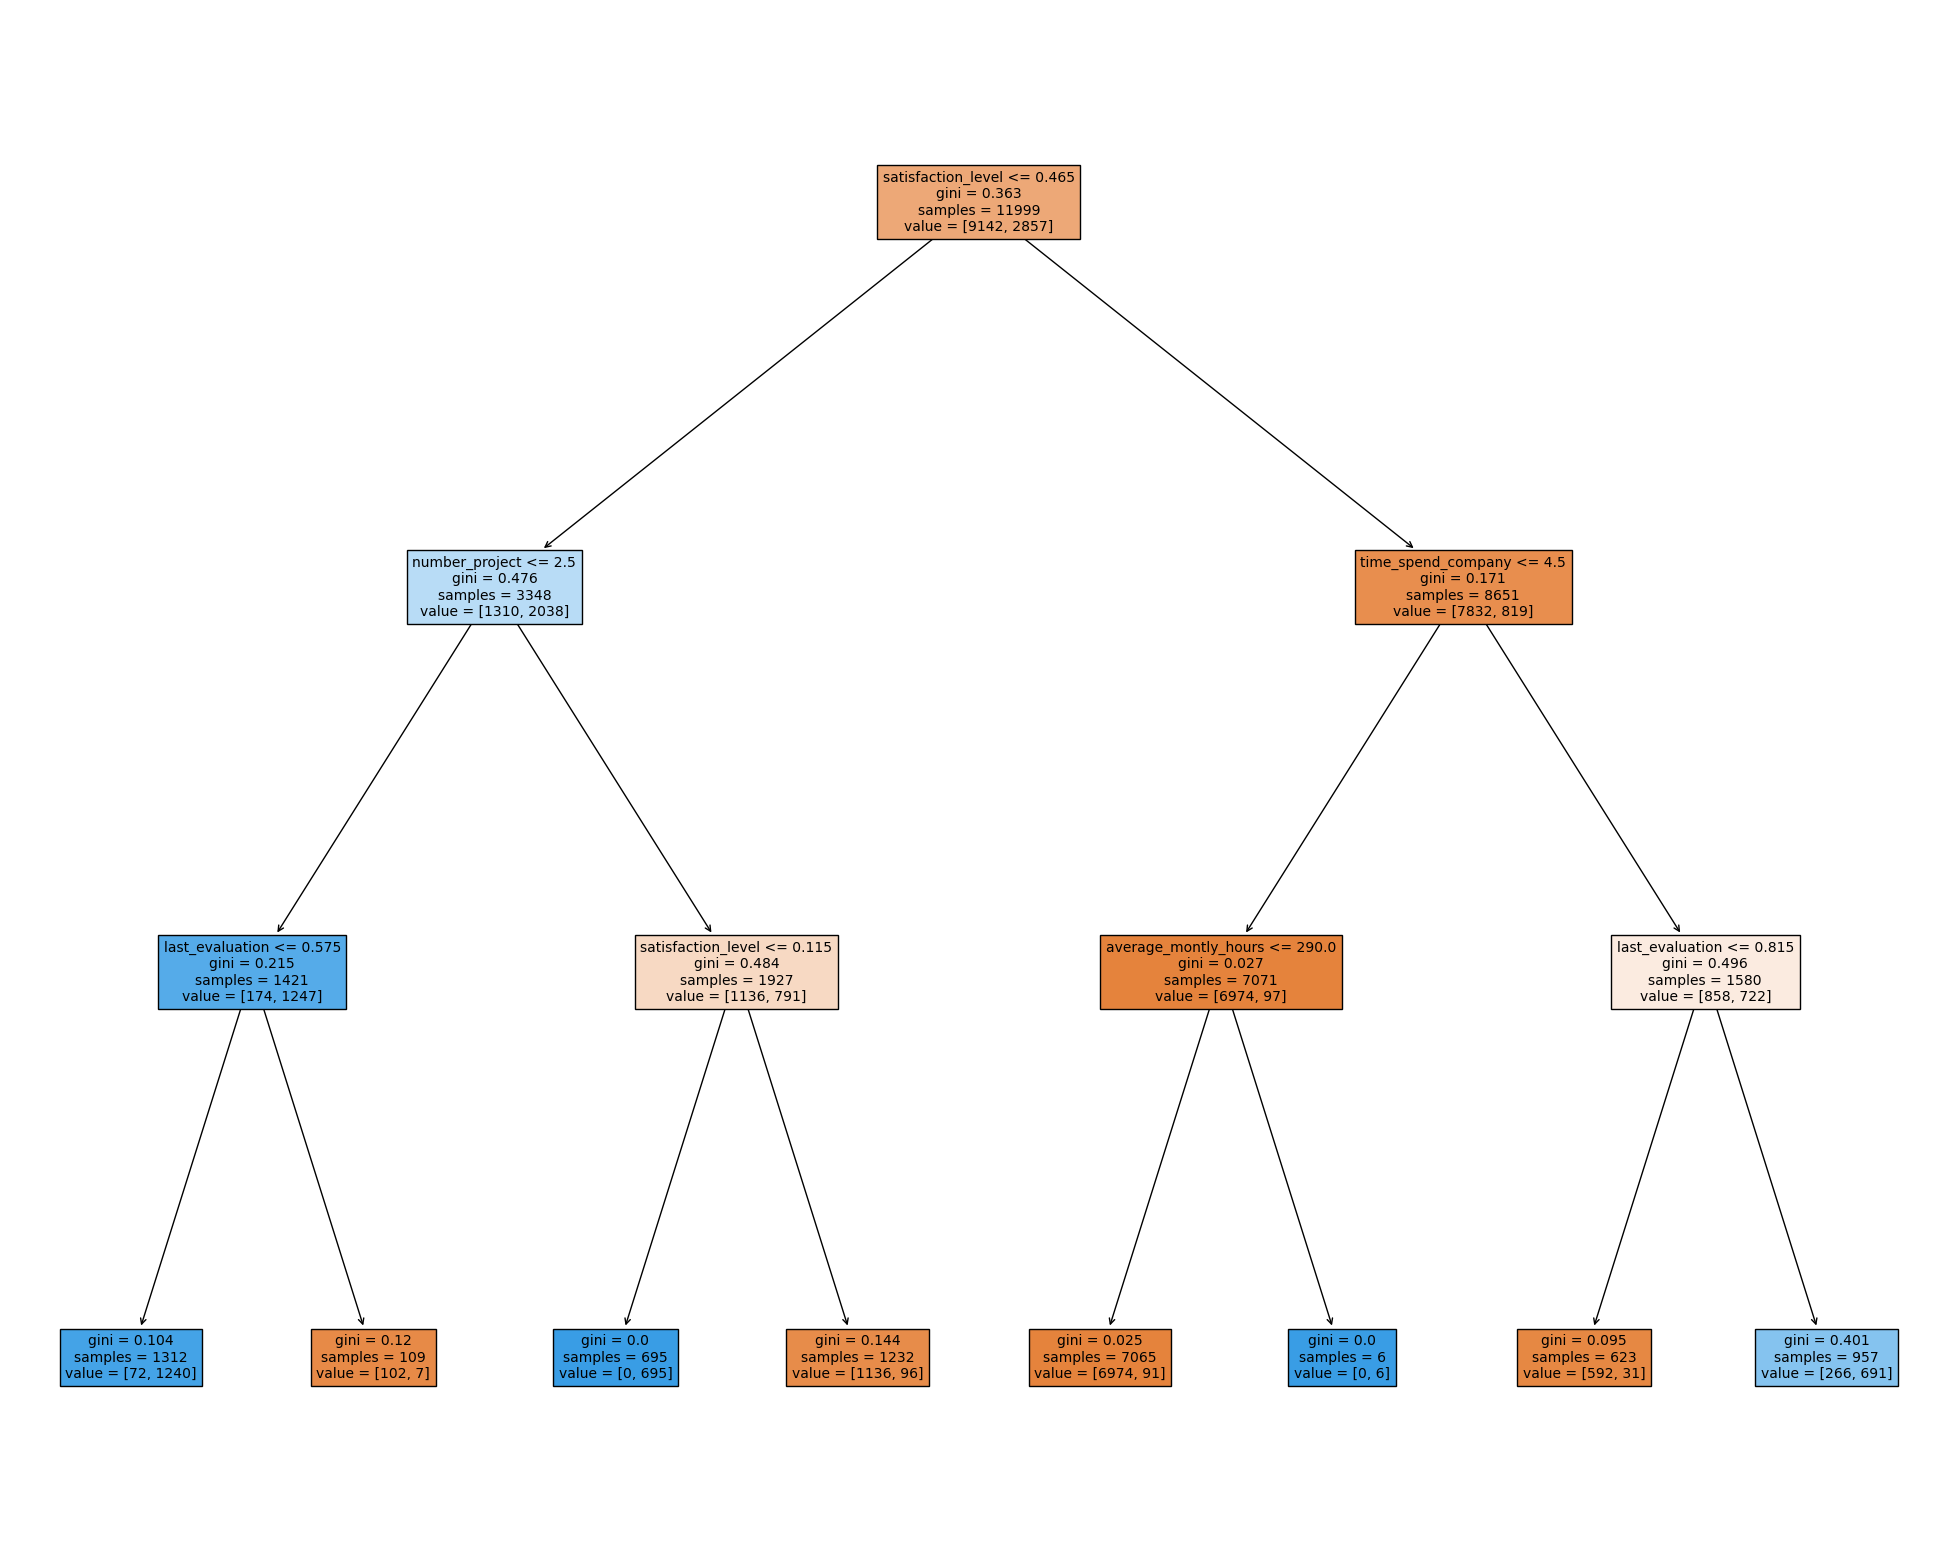

In [3]:
## Defining the input and target variables
X = turnover.drop(columns = ['left'], axis = 1)
Y = turnover['left']

## Splitting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

#Building decision tree
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

fig = plt.figure(figsize = (25,20))
plot_tree(tree_md, feature_names = X_train.columns, filled = True)

[Text(0.5, 0.875, 'satisfaction_level <= 0.465\ngini = 0.363\nsamples = 11999\nvalue = [9142, 2857]'),
 Text(0.25, 0.625, 'number_project <= 2.5\ngini = 0.479\nsamples = 3346\nvalue = [1329, 2017]'),
 Text(0.125, 0.375, 'last_evaluation <= 0.575\ngini = 0.224\nsamples = 1375\nvalue = [177, 1198]'),
 Text(0.0625, 0.125, 'gini = 0.111\nsamples = 1270\nvalue = [75, 1195]'),
 Text(0.1875, 0.125, 'gini = 0.056\nsamples = 105\nvalue = [102, 3]'),
 Text(0.375, 0.375, 'satisfaction_level <= 0.115\ngini = 0.486\nsamples = 1971\nvalue = [1152, 819]'),
 Text(0.3125, 0.125, 'gini = 0.0\nsamples = 724\nvalue = [0, 724]'),
 Text(0.4375, 0.125, 'gini = 0.141\nsamples = 1247\nvalue = [1152, 95]'),
 Text(0.75, 0.625, 'time_spend_company <= 4.5\ngini = 0.175\nsamples = 8653\nvalue = [7813, 840]'),
 Text(0.625, 0.375, 'average_montly_hours <= 290.5\ngini = 0.031\nsamples = 7082\nvalue = [6969, 113]'),
 Text(0.5625, 0.125, 'gini = 0.029\nsamples = 7074\nvalue = [6969, 105]'),
 Text(0.6875, 0.125, 'gini = 

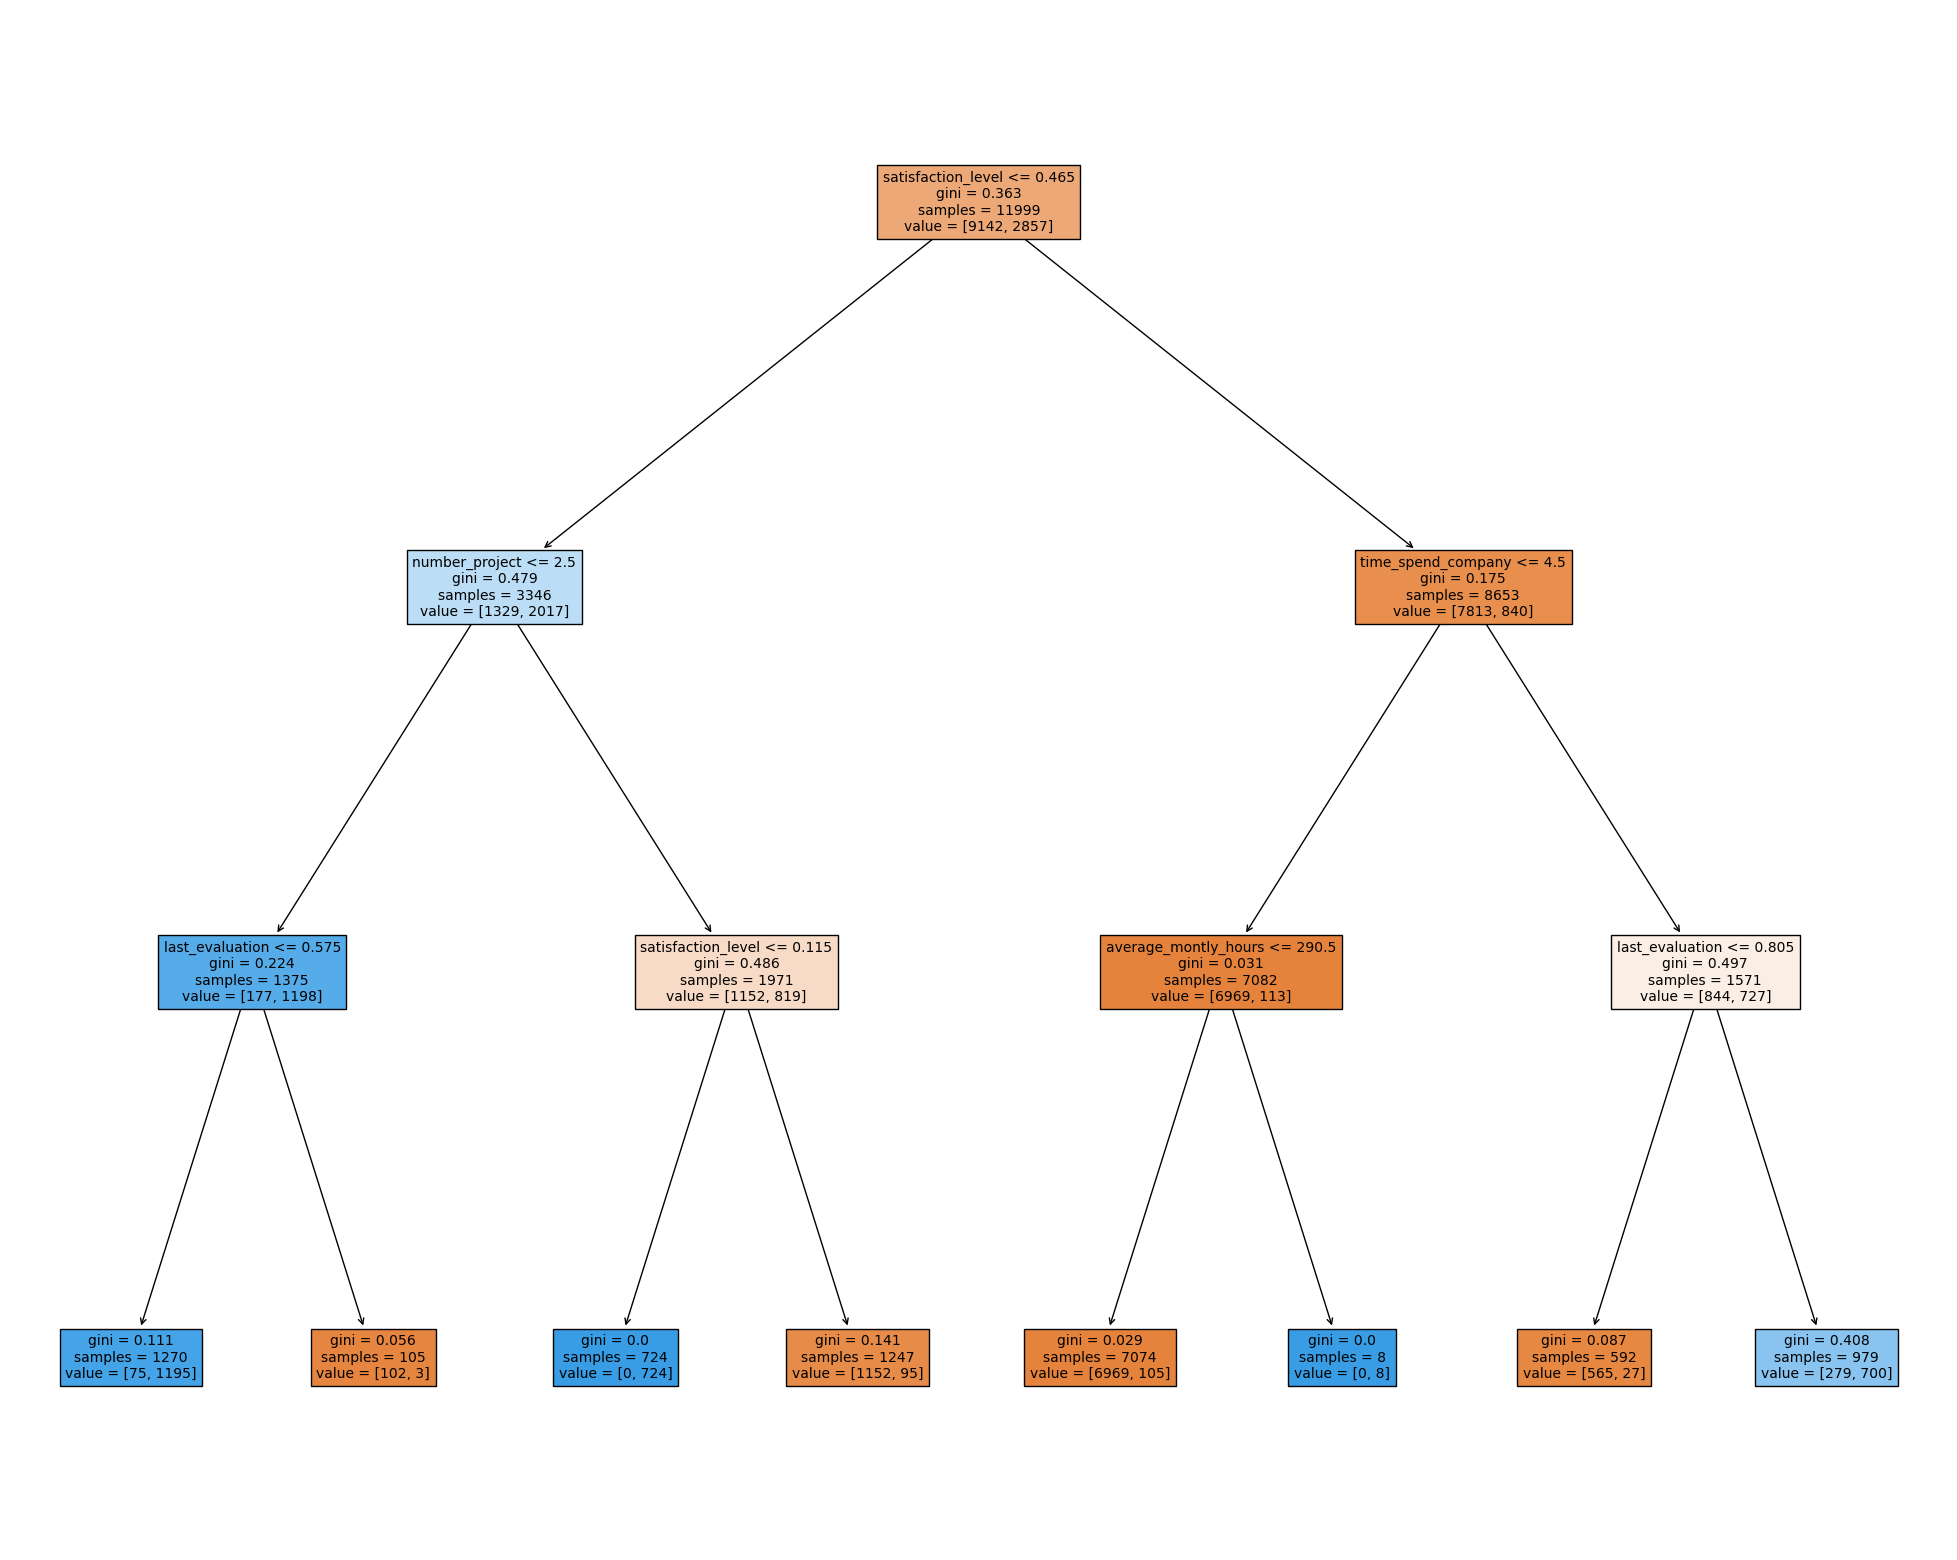

In [4]:
## Defining the input and target variables
X = turnover.drop(columns = ['left'], axis = 1)
Y = turnover['left']

## Splitting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

#Building decision tree
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

fig = plt.figure(figsize = (25,20))
plot_tree(tree_md, feature_names = X_train.columns, filled = True)

[Text(0.5, 0.875, 'satisfaction_level <= 0.465\ngini = 0.363\nsamples = 11999\nvalue = [9142, 2857]'),
 Text(0.25, 0.625, 'number_project <= 2.5\ngini = 0.478\nsamples = 3318\nvalue = [1308, 2010]'),
 Text(0.125, 0.375, 'last_evaluation <= 0.575\ngini = 0.214\nsamples = 1394\nvalue = [170, 1224]'),
 Text(0.0625, 0.125, 'gini = 0.113\nsamples = 1294\nvalue = [78, 1216]'),
 Text(0.1875, 0.125, 'gini = 0.147\nsamples = 100\nvalue = [92, 8]'),
 Text(0.375, 0.375, 'satisfaction_level <= 0.115\ngini = 0.483\nsamples = 1924\nvalue = [1138, 786]'),
 Text(0.3125, 0.125, 'gini = 0.0\nsamples = 698\nvalue = [0, 698]'),
 Text(0.4375, 0.125, 'gini = 0.133\nsamples = 1226\nvalue = [1138, 88]'),
 Text(0.75, 0.625, 'time_spend_company <= 4.5\ngini = 0.176\nsamples = 8681\nvalue = [7834, 847]'),
 Text(0.625, 0.375, 'average_montly_hours <= 290.5\ngini = 0.028\nsamples = 7088\nvalue = [6986, 102]'),
 Text(0.5625, 0.125, 'gini = 0.026\nsamples = 7080\nvalue = [6986, 94]'),
 Text(0.6875, 0.125, 'gini = 0.

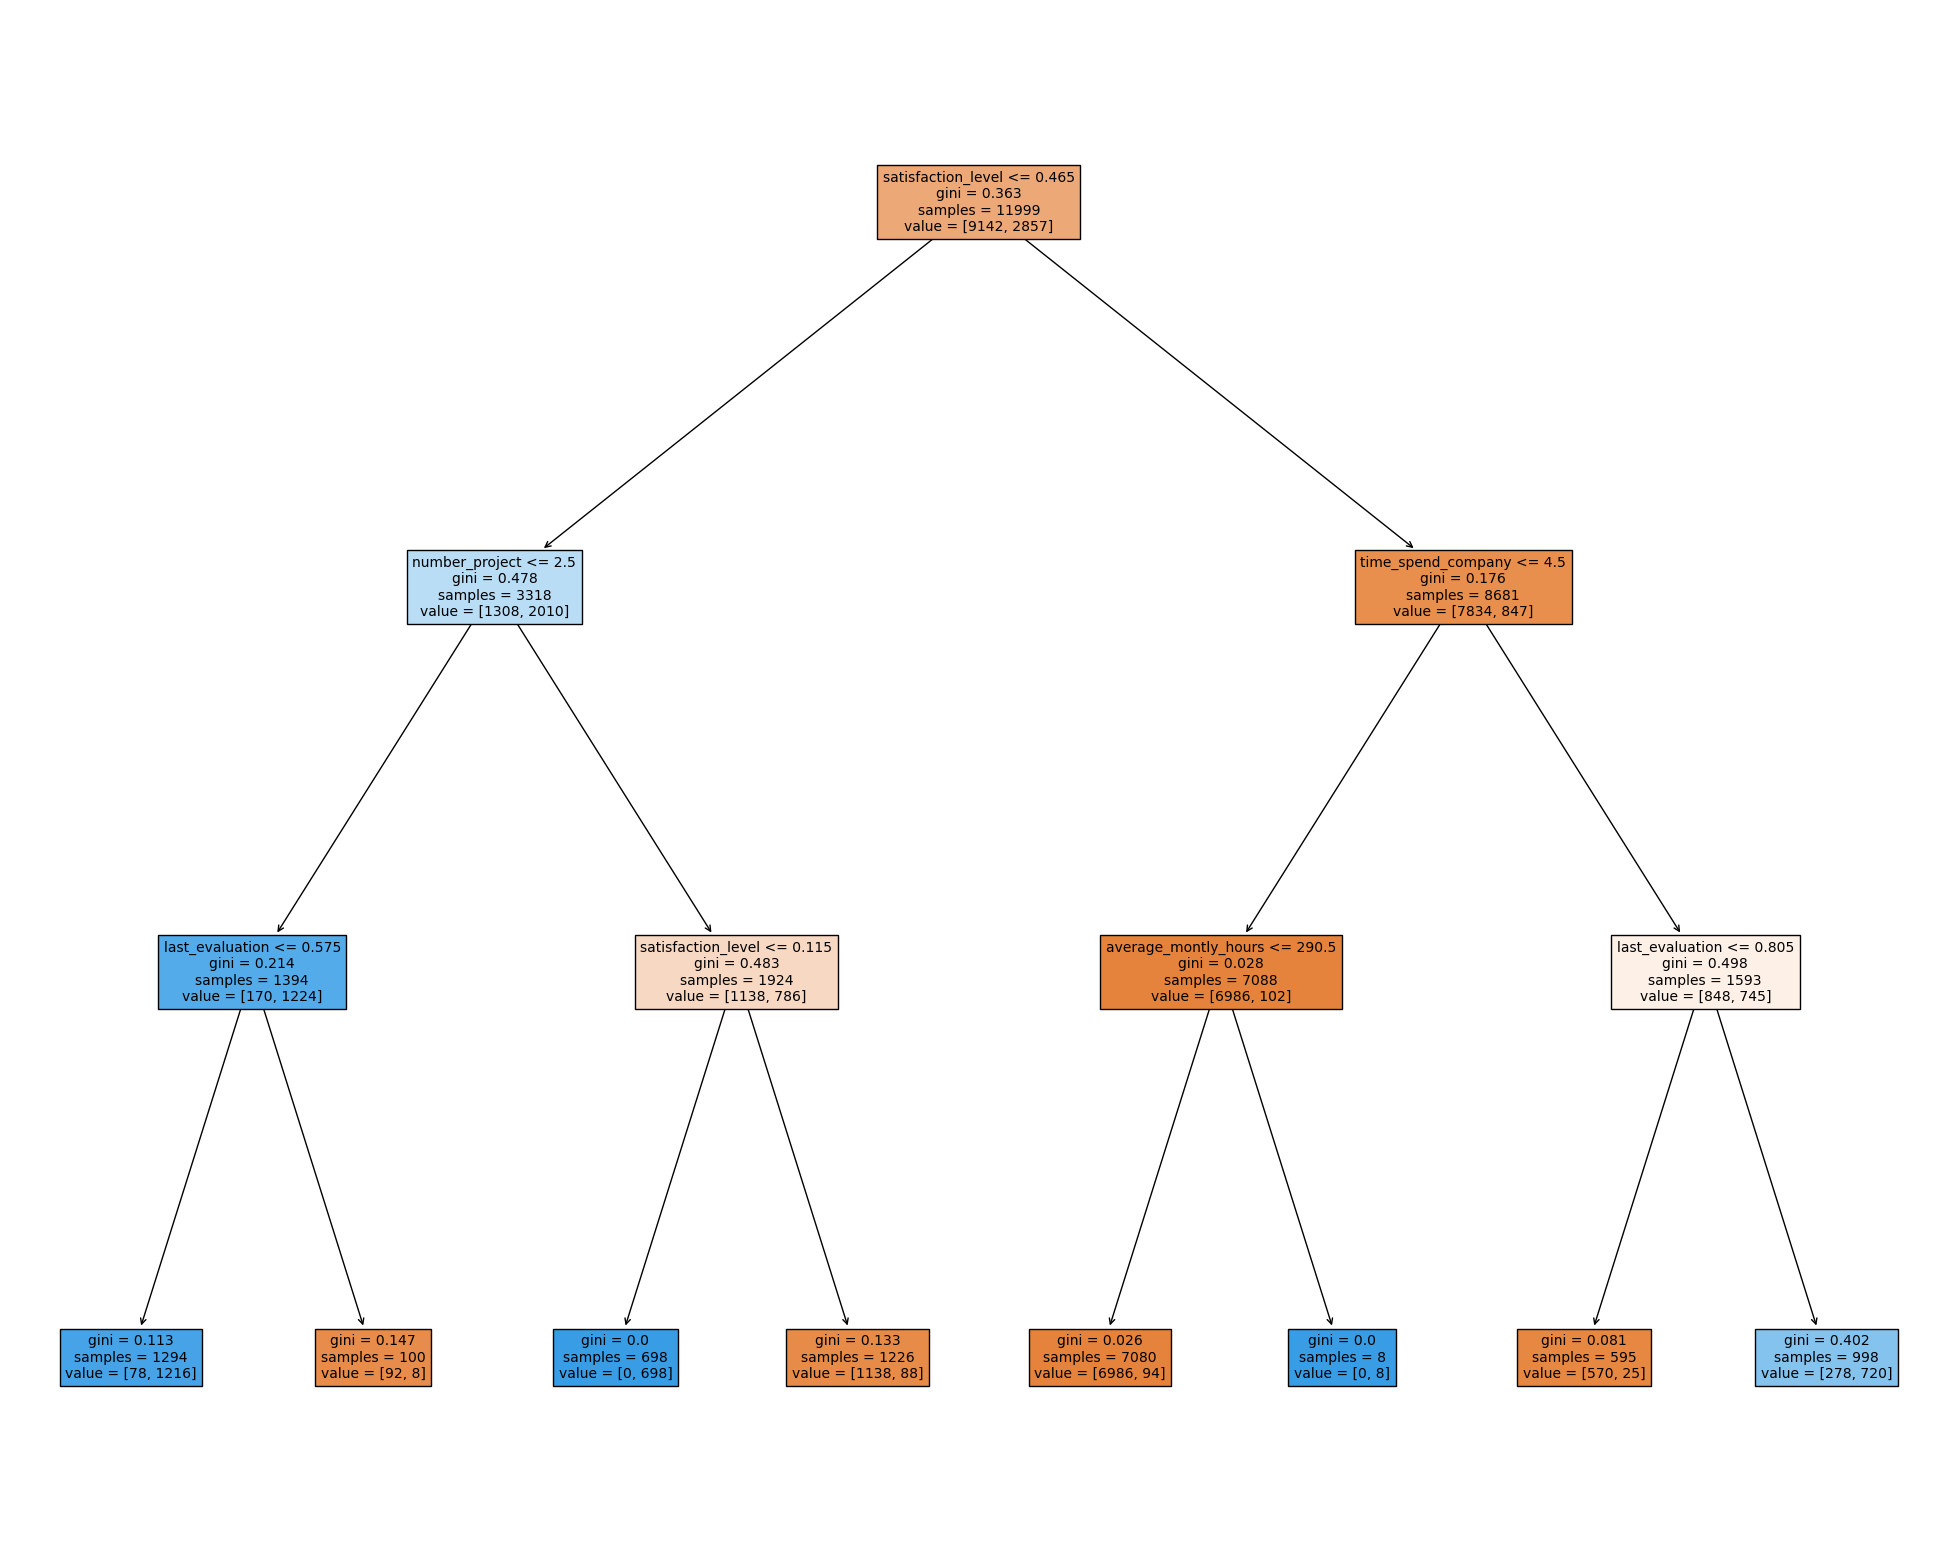

In [5]:
## Defining the input and target variables
X = turnover.drop(columns = ['left'], axis = 1)
Y = turnover['left']

## Splitting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

#Building decision tree
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

fig = plt.figure(figsize = (25,20))
plot_tree(tree_md, feature_names = X_train.columns, filled = True)

In [7]:
## Engineering features from the decision tree model
turnover['interaction_1'] = np.where(((turnover['satisfaction_level'] >= 0.115) &
                                     (turnover['satisfaction_level'] <= 0.465) &
                                     (turnover['number_project'] > 2.5)), 1, 0)

turnover['interaction_2'] = np.where(((turnover['satisfaction_level'] <= 0.465) &
                                     (turnover['number_project'] <= 2.5) &
                                     (turnover['last_evaluation'] <=0.575)), 1, 0)

turnover['interaction_3'] = np.where(((turnover['satisfaction_level'] > 0.465) &
                                     (turnover['time_spend_company'] <= 4.5) &
                                     (turnover['average_montly_hours'] <= 290.5)), 1, 0)

turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales_IT,sales_RandD,...,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium,interaction_1,interaction_2,interaction_3
0,0.38,0.53,2,157,3,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0.11,0.88,7,272,4,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
